In [5]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
import param_generation as pg
import helpers as hp
from IPython.display import Audio
import random
#let's play the sound given the parameters
import imp
imp.reload(pg)
imp.reload(hp)

sr=41000
score_cols=['clap', 'guitar', 'hat', 'kick', 'noise', 'piano', 'rim', 'shake', 'snare', 'synth', 'tom', 'voc']
classes_ranked=[c+"_rank" for c in score_cols]
param_cols=[ 'oscType_0', 'isNoise_0', 
      'A_0', 'D_0', 'S_0', 'R_0', 'numOscPitches_0', 'initPitch_0', 'pitchPathMag_0', 
      'pitchPathAccel_0', 'amplitude_0', 'bpCutLow_0', 'bpCutHigh_0', 'bpOrder_0', 'length_0', 
      'start_0', 'pitch0_0', 'pitch1_0', 'pitch2_0', 'pitch3_0', 'pitch4_0']
pc_no_num=[x[0:-2] for x in param_cols] # param columns with no _# 
df = pd.read_csv("s2.csv",error_bad_lines=False)

In [12]:
df.columns=[*classes_ranked,*score_cols,*param_cols]
df[score_cols].describe().loc[["mean","std","25%","50%","75%"]]

,clap,guitar,hat,kick,noise,piano,rim,shake,snare,synth,tom,voc
mean,0.021978,0.066899,0.103744,0.102347,0.115501,0.058644,0.039092,0.059911,0.050513,0.182863,0.089871,0.108635
std,0.025288,0.036501,0.026018,0.038780,0.024166,0.045832,0.032263,0.045299,0.035565,0.043157,0.039614,0.031572
25%,0.000000,0.041036,0.084976,0.077447,0.100088,0.019893,0.008212,0.016676,0.022957,0.158934,0.062043,0.087272
50%,0.014516,0.066906,0.101474,0.100790,0.114027,0.054759,0.037042,0.061137,0.045724,0.184690,0.091359,0.106794
75%,0.035652,0.092223,0.119727,0.123795,0.129700,0.089139,0.062886,0.095445,0.073654,0.208942,0.119427,0.128306


In [13]:
df.columns=[*classes_ranked,*score_cols,*param_cols]
df[classes_ranked].describe().loc[["mean","std","25%","50%","75%"]]

,clap_rank,guitar_rank,hat_rank,kick_rank,noise_rank,piano_rank,rim_rank,shake_rank,snare_rank,synth_rank,tom_rank,voc_rank
mean,10.576717,7.556631,4.891862,5.112932,3.943939,8.076307,9.444420,7.922089,8.531418,1.549781,5.946208,4.447697
std,1.625761,2.612859,2.020698,2.620997,1.651619,3.083582,2.105469,3.079209,2.536666,1.456721,2.856517,2.145586
25%,10.000000,6.000000,3.000000,3.000000,3.000000,6.000000,8.000000,6.000000,7.000000,1.000000,3.000000,3.000000
50%,11.000000,8.000000,5.000000,5.000000,4.000000,8.000000,10.000000,8.000000,9.000000,1.000000,6.000000,4.000000
75%,12.000000,10.000000,6.000000,7.000000,5.000000,11.000000,11.000000,11.000000,10.000000,1.000000,8.000000,6.000000


<Figure size 1080x540 with 0 Axes>

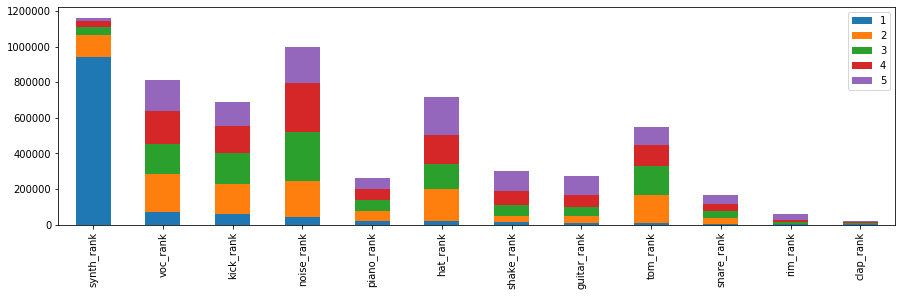

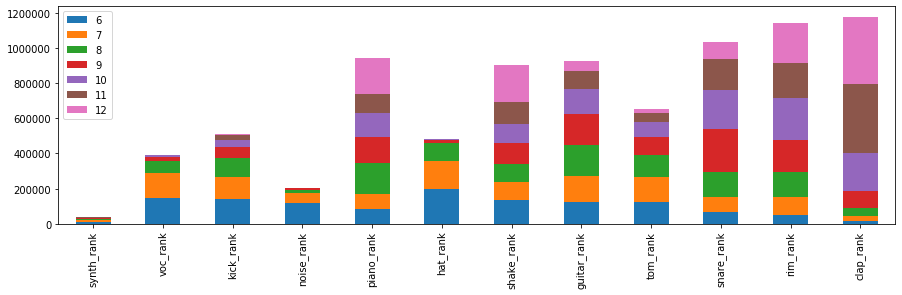

In [14]:
#visualizing ranks per group
gc=pd.DataFrame(columns=range(1,5))
for c in classes_ranked:
    gc=gc.append(df[c].astype(int).value_counts())

gc=gc.sort_values(by=[1,2],ascending=False)
fig = plt.gcf()
fig.set_size_inches(15, 7.5)

gc[list(range(1,6))].plot(kind="bar",figsize=(15,4),stacked=True)

gc[list(range(6,13))].plot(kind="bar",figsize=(15,4),stacked=True)

In [33]:
#convert params ina  row to a sound and play it
def rToParams(r,pset,n=0):

    pset.oscType=r["oscType_%d"%(n,)]
    pset.isNoise=r["isNoise_%d"%(n,)]
    pset.A=r["A_%d"%(n,)]
    pset.D=r["D_%d"%(n,)]
    pset.S=r["S_%d"%(n,)]
    pset.R=r["R_%d"%(n,)]
    #pitches
    pset.numOscPitches=r["numOscPitches_%d"%(n,)]
    pset.initPitch=r["initPitch_%d"%(n,)]
    pset.pitchPathMag=r["pitchPathMag_%d"%(n,)]
    pset.pitchPathAccel=r["pitchPathAccel_%d"%(n,)]
    #######
    pset.amplitude=r["amplitude_%d"%(n,)]
    pset.bpCutLow,pset.bpCutHigh=r["bpCutLow_%d"%(n,)],r["bpCutHigh_%d"%(n,)]
    pset.bpOrder=r["bpOrder_%d"%(n,)]
    pset.length=r["length_%d"%(n,)]
    pset.start=r["start_%d"%(n,)]
    pset.pitches=[]
    return pset
g="snare"

selection=df[(df[g]>0.2) & (df[g+"_rank"]<3) & (df["synth_rank"]>3)].reset_index(drop=True)
r=selection.iloc[random.randint(0,selection.shape[0]-1)]
print(selection.shape)

r=r[param_cols]
pset=pg.RandomParams()
pset=rToParams(r,pset)
out=pg.ensemble([pset])

Audio(hp.memToAud(out),rate=sr, autoplay=True)


(105, 45)


In [6]:
from ipywidgets import GridspecLayout
from ipywidgets import Button, Layout, jslink, IntText, IntSlider

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def create_expanded_button(description, button_style):
    return Button(description=description, button_style=button_style, layout=Layout(height='auto', width='auto'))

grid = GridspecLayout(4, 3)

for i in range(4):
    for j in range(3):
        grid[i, j] = create_expanded_button('Button {} - {}'.format(i, j), 'warning')

a = widgets.IntSlider()
b = widgets.IntSlider()
c = widgets.IntSlider()
ui = widgets.HBox([a, b, c])
def f(a, b, c):
    print((a, b, c))

out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})


(0, 0, 0)


Output()